In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, BatchNormalization, Add, ZeroPadding2D, Input, Dense, MaxPooling2D

class ResBlock:
    def __init__(self, out_channels, in_channels=None, strides=1):
        self.out_channels = out_channels
        self.in_channels = in_channels if in_channels else out_channels
        self.strides = strides
        
        
    def __call__(self, x):    
        res = BatchNormalization()(x)
        res_1 = Activation('relu')(res)
        
        res = Conv2D(filters=self.out_channels//4, kernel_size=(1,1), strides=1, use_bias=False)(res_1)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        # res = ZeroPadding2D(padding=(1,1))(res)
        res = Conv2D(filters=self.out_channels//4, kernel_size=(3,3), strides=self.strides, padding='same')(res)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        res = Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=1, use_bias=False)(res)
        
        if self.strides != 1 or self.in_channels != self.out_channels:
            identity = Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=self.strides, use_bias=False)(res_1)
        else:
            identity = x
        output = Add()([identity, res])
        return output
    
    
class MaxPool2D:
    def __init__(self, pool_size=(3,3), strides=2, padding=(1,1)):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
        
    def __call__(self, x):
        # padd = ZeroPadding2D(padding=self.padding)(x)
        # pool = MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding='same')(padd)
        pool = MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding='same')(x)
        return pool

class AvgPool2D:
    def __init__(self, pool_size=(3,3), strides=2, padding=(1,1)):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
        
    def __call__(self, x):
        padd = ZeroPadding2D(padding=self.padding)(x)
        pool = AveragePooling2D(pool_size=self.pool_size, strides=self.strides, padding='valid')(padd)
        return pool

In [0]:
import tensorflow as tf
# from basic_module import ResBlock, MaxPool2D
from tensorflow.keras.layers import Activation, Conv2D, BatchNormalization, Add, ZeroPadding2D, MaxPooling2D, UpSampling2D, Multiply, AveragePooling2D, Flatten, Dropout
    

class AttentionModule_stage1:
    def __init__(self, channels):
        self.channels = channels
    
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)

        out_mpool1 = MaxPool2D()(x)
        out_softmax1 = ResBlock(channels)(out_mpool1)
        out_skip1_connection = ResBlock(channels)(out_softmax1)

        out_mpool2 = MaxPool2D()(out_softmax1)
        out_softmax2 = ResBlock(channels)(out_mpool2)
        out_softmax2 = ResBlock(channels)(out_softmax2)

        out_interp2 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax2), out_softmax1])
        out = Add()([out_interp2, out_skip1_connection])

        out_softmax3 = ResBlock(channels)(out)
        out_interp1 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax3), out_trunk])

        out_softmax4 = BatchNormalization()(out_interp1)
        out_softmax4 = Activation('relu')(out_softmax4)
        out_softmax4 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax4)
        out_softmax4 = BatchNormalization()(out_softmax4)
        out_softmax4 = Activation('relu')(out_softmax4)
        out_softmax4 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax4)
        out_softmax4 = Activation('sigmoid')(out_softmax4)
        
        out = Add()([tf.ones_like(out_softmax4), out_softmax4])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    
    
class AttentionModule_stage2:
    def __init__(self, channels):
        self.channels = channels
    
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)

        out_mpool1 = MaxPool2D()(x)
        out_softmax1 = ResBlock(channels)(out_mpool1)
        out_softmax1 = ResBlock(channels)(out_softmax1)

        out_interp1 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax1), out_trunk])
        
        out_softmax2 = BatchNormalization()(out_interp1)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = BatchNormalization()(out_softmax2)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = Activation('sigmoid')(out_softmax2)
        
        out = Add()([tf.ones_like(out_softmax2), out_softmax2])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    
    
class AttentionModule_stage3:
    def __init__(self, channels):
        self.channels = channels
    
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)
                
        out_softmax1 = ResBlock(channels)(x)
        out_softmax1 = ResBlock(channels)(out_softmax1)
        
        out_softmax2 = BatchNormalization()(out_softmax1)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = BatchNormalization()(out_softmax2)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = Activation('sigmoid')(out_softmax2)
        
        out = Add()([tf.ones_like(out_softmax2), out_softmax2])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    

In [0]:
class ResidualAttentionModel_32input_red:

    def __init__(self, classes=10):
        self.classes = classes
        
    def __call__(self, x):
        classes = self.classes
                
        # x = ZeroPadding2D(padding=(3,3))(x)
        x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # x = MaxPool2D()(x)
        x = ResBlock(32, in_channels=32)(x)
        x = AttentionModule_stage1(32)(x)
        x = ResBlock(64, in_channels=32, strides=2)(x)
        x = AttentionModule_stage2(64)(x)
        x = ResBlock(128, in_channels=64, strides=2)(x)
        x = AttentionModule_stage3(128)(x)
        x = ResBlock(256, in_channels=128)(x)
#        x = ResBlock(1024)(x)
        x = ResBlock(256)(x)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AvgPool2D(pool_size=(8,8), strides=1, padding=(0,0))(x)
        
        x = Conv2D(classes, kernel_size=(1,1))(x)
        x = Flatten()(x)

        return x

In [0]:
import numpy as np
from tensorflow.keras import backend as K

def cosine_decay_warmup(global_step, lr_base, num_steps, warmup_steps=0):

    lr = 0.5 * lr_base * (1 + np.cos( np.pi *
        (global_step - warmup_steps) / float(num_steps - warmup_steps)))
    if warmup_steps > 0:
        slope = lr_base / warmup_steps
        lr = np.where(global_step < warmup_steps, slope * global_step, lr)
    return np.where(global_step > num_steps, 0.0, lr)


class Scheduler(tf.keras.callbacks.Callback):

    def __init__(self, lr_base, num_epochs,
                 warmup_epochs=0, num_sample = 50000, batch_size=64):

        super(Scheduler, self).__init__()
        self.lr_base = lr_base
        self.num_steps = int(num_epochs * num_sample / batch_size)
        self.global_step = 0
        self.warmup_steps = int(warmup_epochs * num_sample / batch_size)


    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1


    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_warmup(global_step=self.global_step,
                                 lr_base=self.lr_base,
                                 num_steps=self.num_steps,
                                 warmup_steps=self.warmup_steps,
                                 )
        K.set_value(self.model.optimizer.lr, lr)

num_sample = 50000
epochs = 250
batch_size = 64
warmup_epochs = 25
lr_base = 0.001


warm_up_lr = Scheduler(lr_base=lr_base,
                       num_epochs=epochs,
                       warmup_epochs=warmup_epochs, 
                       num_sample = num_sample, 
                       batch_size=batch_size,
                       )

In [0]:
checkpoint_path = '/content'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
from tensorflow.keras import Model

model_in = Input((32, 32, 3))

model_out = ResidualAttentionModel_32input_red()(model_in)
model_out = Dropout(0.2)(model_out)
model_out = Activation('softmax')(model_out)

red_model = Model(inputs=model_in, outputs=model_out)

red_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
red_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 32, 32, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_172 (BatchN (None, 32, 32, 32)   128         conv2d_178[0][0]                 
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 32, 32, 32)   0           batch_normalization_172[0][0]    
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

num_classes = 10 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


def get_cutout(sl=0.02, sh=0.4, rand_r=0.3):
    def cutout(img):
        if np.random.rand() > 0.5:
            return img
        while True:
            s = np.random.uniform(sl, sh) * 32 * 32
            r = np.random.uniform(rand_r, 1/rand_r)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, 32)
            top = np.random.randint(0, 32)
            if left + w <= 32 and top + h <= 32:
                break
        img[top:top + h, left:left + w, :] = np.random.uniform(0, 1)
        return img
    return cutout


datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_cutout()
    )

datagen.fit(x_train)

In [0]:
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])  

Epoch 1/250
781/781 [==============================] - ETA: 0s - loss: 2.2963 - accuracy: 0.1560
Epoch 00001: saving model to /content
781/781 [==============================] - 35s 44ms/step - loss: 2.2963 - accuracy: 0.1560 - val_loss: 2.0136 - val_accuracy: 0.2735
Epoch 2/250
781/781 [==============================] - ETA: 0s - loss: 1.9596 - accuracy: 0.2900
Epoch 00002: saving model to /content
781/781 [==============================] - 33s 42ms/step - loss: 1.9596 - accuracy: 0.2900 - val_loss: 1.7538 - val_accuracy: 0.3712
Epoch 3/250
780/781 [============================>.] - ETA: 0s - loss: 1.8107 - accuracy: 0.3454
Epoch 00003: saving model to /content
781/781 [==============================] - 33s 43ms/step - loss: 1.8107 - accuracy: 0.3455 - val_loss: 1.6159 - val_accuracy: 0.4064
Epoch 4/250
780/781 [============================>.] - ETA: 0s - loss: 1.7099 - accuracy: 0.3820
Epoch 00004: saving model to /content
781/781 [==============================] - 33s 43ms/step - lo

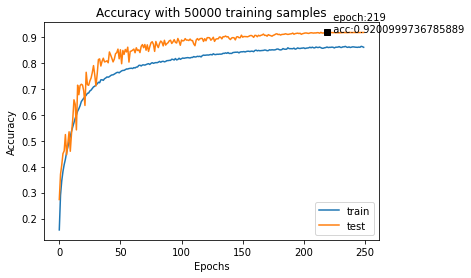

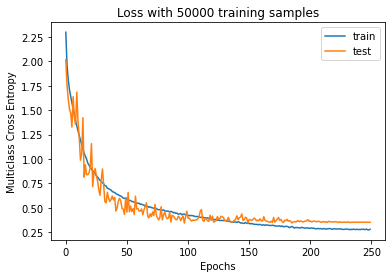

In [0]:
import matplotlib.pyplot as plt



plt.figure()
plt.plot(history_red.history['accuracy'], label='train')
plt.plot(history_red.history['val_accuracy'], label='test')

max_idx=np.argmax(history_red.history['val_accuracy'])
plt.plot(max_idx, history_red.history['val_accuracy'][max_idx], 'ks')
plt.annotate('  epoch:'+str(max_idx)+'\n'+'  acc:'+str(history_red.history['val_accuracy'][max_idx]),
             xytext=(max_idx,history_red.history['val_accuracy'][max_idx]),
             xy=(max_idx,history_red.history['val_accuracy'][max_idx]))

plt.title('Accuracy with 50000 training samples')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(history_red.history['loss'], label='train')
plt.plot(history_red.history['val_loss'], label='test')
plt.title('Loss with 50000 training samples')
plt.xlabel('Epochs')
plt.ylabel('Multiclass Cross Entropy')
plt.legend()


In [0]:
red_model.evaluate(x_train, y_train)

1563/1563 [==============================] - 11s 7ms/step - loss: 0.0139 - accuracy: 0.9959


[0.013866527006030083, 0.9958999752998352]

In [0]:
red_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.3528 - accuracy: 0.9192


[0.35276347398757935, 0.9192000031471252]